Trimean Values Table:
     Measure    Group  Baseline  Treatment  3 Months  6 Months  \
0  Frequency  Treated    5.2500     4.4375    5.1875    4.3750   
1  Frequency  Control    1.6875     4.5625    4.7500    5.1875   
2       Pain  Treated    6.5000     5.6875    6.5000    3.1875   
3       Pain  Control    5.3125     4.1875    4.0625    4.6250   
4    Urgency  Treated    5.7500     3.9375    5.7500    4.5625   
5    Urgency  Control    3.2500     4.2500    4.6875    5.9375   

   3 Months Posttreatment  6 Months Posttreatment   P-value  
0                  0.3750                  0.4375  0.942425  
1                 -0.5000                 -0.1875  0.942425  
2                  0.9375                 -1.1875  0.158497  
3                 -0.1875                  0.0000  0.158497  
4                  1.3750                 -0.0625  0.440054  
5                  0.0625                  0.3750  0.440054  


C:\Users\Gigabyte\AppData\Local\Temp\ipykernel_10772\383506755.py:178: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
C:\Users\Gigabyte\AppData\Local\Temp\ipykernel_10772\383506755.py:178: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
C:\Users\Gigabyte\AppData\Local\Temp\ipykernel_10772\383506755.py:178: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


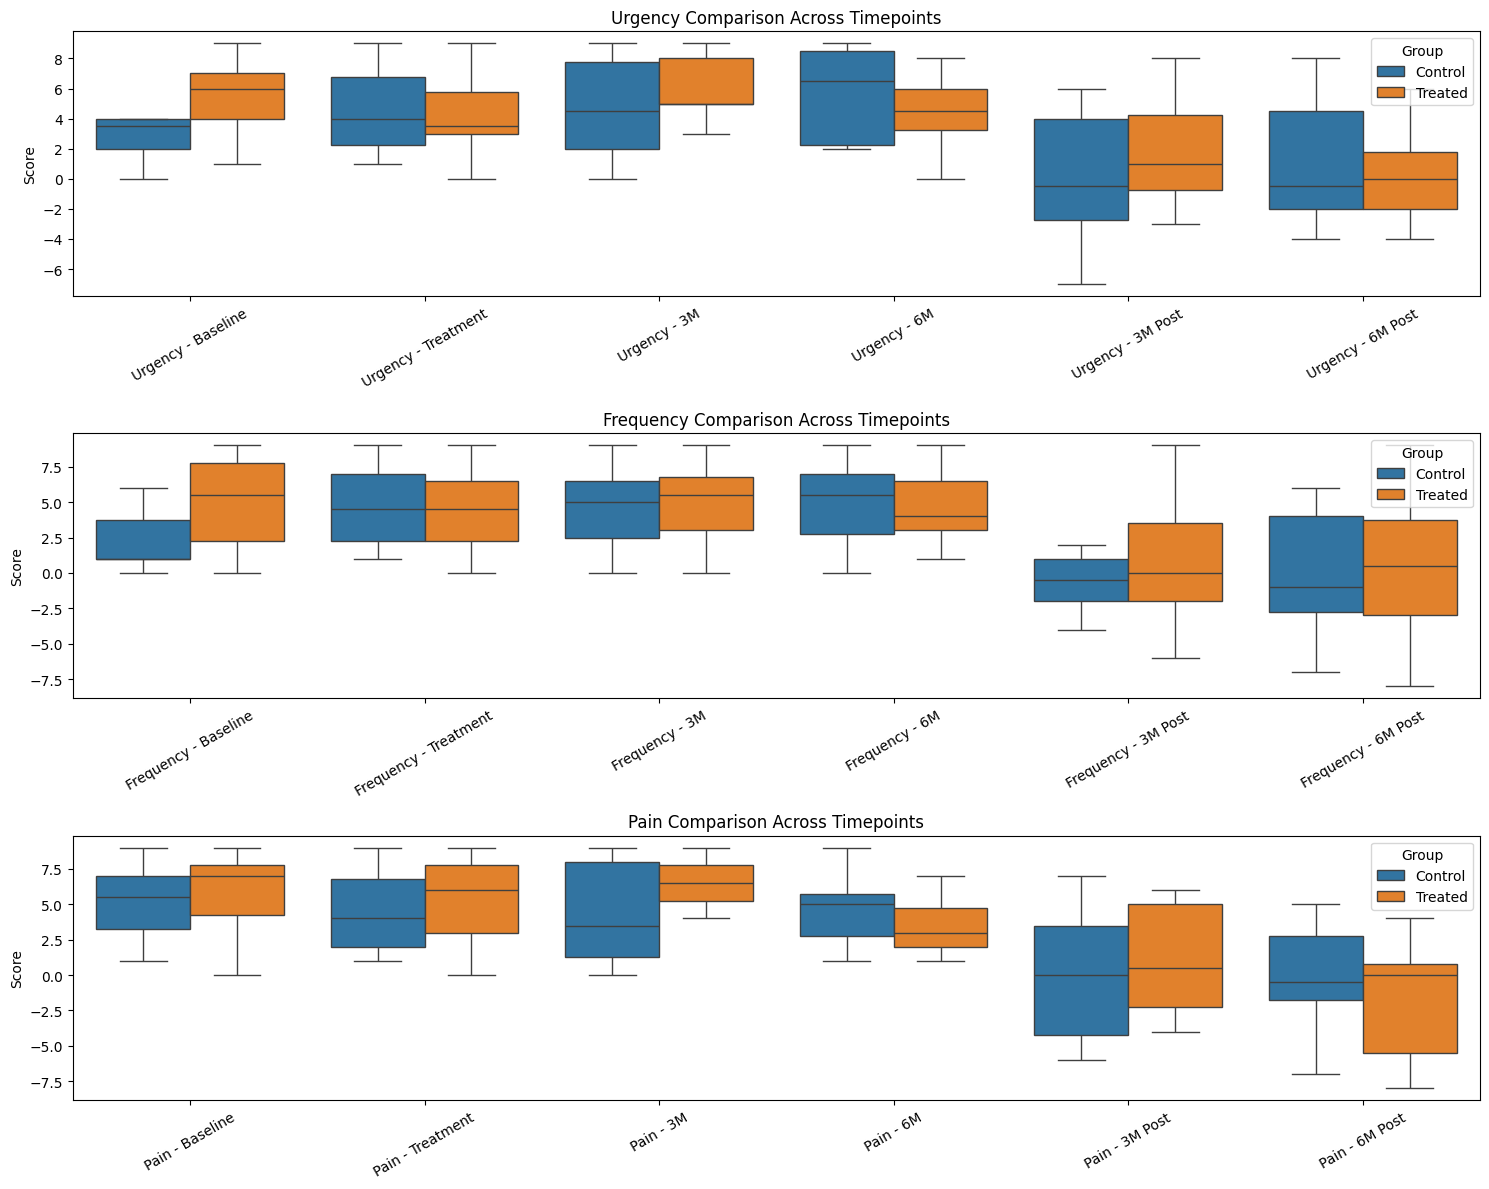

In [20]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv
from pulp import LpMinimize, LpProblem, LpVariable, lpSum
from scipy.stats import trim_mean, ttest_ind

# Step 1: Defining the Matching Framework
data = pd.DataFrame({
    'id': range(1, 21),
    'urgency_baseline': np.random.randint(0, 10, 20),
    'urgency_t': np.random.randint(0, 10, 20),
    'urgency_3m': np.random.randint(0, 10, 20),
    'urgency_6m' : np.random.randint(0, 10, 20),
    'frequency_baseline': np.random.randint(0, 10, 20),
    'frequency_t': np.random.randint(0, 10, 20),
    'frequency_3m': np.random.randint(0, 10, 20),
    'frequency_6m' : np.random.randint(0, 10, 20),
    'pain_baseline': np.random.randint(0, 10, 20),
    'pain_t': np.random.randint(0, 10, 20),
    'pain_3m': np.random.randint(0, 10, 20),
    'pain_6m' : np.random.randint(0, 10, 20),
    'age': np.random.randint(20, 80, 20),
    'gender': np.random.choice([0, 1], 20),
    'treated': np.random.choice([0, 1], 20)
})

data['urgency_3m_post'] = data['urgency_3m'] - data['urgency_t']
data['urgency_6m_post'] = data['urgency_6m'] - data['urgency_t']
data['frequency_3m_post'] = data['frequency_3m'] - data['frequency_t']
data['frequency_6m_post'] = data['frequency_6m'] - data['frequency_t']
data['pain_3m_post'] = data['pain_3m'] - data['pain_t']
data['pain_6m_post'] = data['pain_6m'] - data['pain_t']


# Compute Trimean
def compute_trimean(series):
    q1, q2, q3 = np.percentile(series, [25, 50, 75])
    return (q1 + 2 * q2 + q3) / 4

def compute_p_value(treated_series, control_series):
    return ttest_ind(treated_series, control_series, equal_var=False).pvalue

# Compute P-values
p_values = [
    compute_p_value(data.loc[data['treated'] == 1, 'frequency_3m'], data.loc[data['treated'] == 0, 'frequency_3m']),
    compute_p_value(data.loc[data['treated'] == 1, 'pain_3m'], data.loc[data['treated'] == 0, 'pain_3m']),
    compute_p_value(data.loc[data['treated'] == 1, 'urgency_3m'], data.loc[data['treated'] == 0, 'urgency_3m'])
]

# Expand p-values to match the correct rows
expanded_p_values = [p for p in p_values for _ in (0, 1)]  # Repeat each p-value for Treated & Control

trimean_results = pd.DataFrame({
    'Measure': ['Frequency', 'Frequency', 'Pain', 'Pain', 'Urgency', 'Urgency'],
    'Group': ['Treated', 'Control', 'Treated', 'Control', 'Treated', 'Control'],
    'Baseline': [
        compute_trimean(data.loc[data['treated'] == 1, 'frequency_baseline']),
        compute_trimean(data.loc[data['treated'] == 0, 'frequency_baseline']),
        compute_trimean(data.loc[data['treated'] == 1, 'pain_baseline']),
        compute_trimean(data.loc[data['treated'] == 0, 'pain_baseline']),
        compute_trimean(data.loc[data['treated'] == 1, 'urgency_baseline']),
        compute_trimean(data.loc[data['treated'] == 0, 'urgency_baseline'])
    ],
    'Treatment': [
        compute_trimean(data.loc[data['treated'] == 1, 'frequency_t']),
        compute_trimean(data.loc[data['treated'] == 0, 'frequency_t']),
        compute_trimean(data.loc[data['treated'] == 1, 'pain_t']),
        compute_trimean(data.loc[data['treated'] == 0, 'pain_t']),
        compute_trimean(data.loc[data['treated'] == 1, 'urgency_t']),
        compute_trimean(data.loc[data['treated'] == 0, 'urgency_t'])
    ],
    '3 Months': [
        compute_trimean(data.loc[data['treated'] == 1, 'frequency_3m']),
        compute_trimean(data.loc[data['treated'] == 0, 'frequency_3m']),
        compute_trimean(data.loc[data['treated'] == 1, 'pain_3m']),
        compute_trimean(data.loc[data['treated'] == 0, 'pain_3m']),
        compute_trimean(data.loc[data['treated'] == 1, 'urgency_3m']),
        compute_trimean(data.loc[data['treated'] == 0, 'urgency_3m'])
    ],
    '6 Months': [
        compute_trimean(data.loc[data['treated'] == 1, 'frequency_6m']),
        compute_trimean(data.loc[data['treated'] == 0, 'frequency_6m']),
        compute_trimean(data.loc[data['treated'] == 1, 'pain_6m']),
        compute_trimean(data.loc[data['treated'] == 0, 'pain_6m']),
        compute_trimean(data.loc[data['treated'] == 1, 'urgency_6m']),
        compute_trimean(data.loc[data['treated'] == 0, 'urgency_6m'])
    ],
    '3 Months Posttreatment': [
        compute_trimean(data.loc[data['treated'] == 1, 'frequency_3m_post']),
        compute_trimean(data.loc[data['treated'] == 0, 'frequency_3m_post']),
        compute_trimean(data.loc[data['treated'] == 1, 'pain_3m_post']),
        compute_trimean(data.loc[data['treated'] == 0, 'pain_3m_post']),
        compute_trimean(data.loc[data['treated'] == 1, 'urgency_3m_post']),
        compute_trimean(data.loc[data['treated'] == 0, 'urgency_3m_post'])
    ],
    '6 Months Posttreatment': [
        compute_trimean(data.loc[data['treated'] == 1, 'frequency_6m_post']),
        compute_trimean(data.loc[data['treated'] == 0, 'frequency_6m_post']),
        compute_trimean(data.loc[data['treated'] == 1, 'pain_6m_post']),
        compute_trimean(data.loc[data['treated'] == 0, 'pain_6m_post']),
        compute_trimean(data.loc[data['treated'] == 1, 'urgency_6m_post']),
        compute_trimean(data.loc[data['treated'] == 0, 'urgency_6m_post'])
    ], 
    'P-value': expanded_p_values
})

print("Trimean Values Table:")
print(trimean_results)


# Step 2: Risk Set Matching
treated = data[data['treated'] == 1].reset_index(drop=True)
control = data[data['treated'] == 0].reset_index(drop=True)

cov_matrix = np.cov(data[['urgency_baseline', 'urgency_t', 'urgency_3m', 'frequency_baseline', 'frequency_t', 'frequency_3m', 'pain_baseline', 'pain_t', 'pain_3m']].T)
cov_inv = inv(cov_matrix)

def compute_distance_matrix(treated, control):
    distances = {}
    for i, t in treated.iterrows():
        for j, c in control.iterrows():
            dist = mahalanobis(t[['urgency_baseline', 'urgency_t', 'urgency_3m', 'frequency_baseline', 'frequency_t', 'frequency_3m', 'pain_baseline', 'pain_t', 'pain_3m']], 
                               c[['urgency_baseline', 'urgency_t', 'urgency_3m', 'frequency_baseline', 'frequency_t', 'frequency_3m', 'pain_baseline', 'pain_t', 'pain_3m']], 
                               cov_inv)
            distances[(i, j)] = dist
    return distances

distance_matrix = compute_distance_matrix(treated, control)

# Visualization
# Updated Visualization Function
def plot_boxplots_with_iqr(data):
    # Reshape the data for plotting
    melted_data = data.melt(
        id_vars=['treated'], 
        value_vars=[
            'urgency_baseline', 'urgency_t', 'urgency_3m', 'urgency_6m', 
            'urgency_3m_post', 'urgency_6m_post', 'frequency_baseline', 'frequency_t', 
            'frequency_3m', 'frequency_6m', 'frequency_3m_post', 'frequency_6m_post',
            'pain_baseline', 'pain_t', 'pain_3m', 'pain_6m', 'pain_3m_post', 'pain_6m_post'
        ],
        var_name='Timepoint',
        value_name='Score'
    )
    
    # Map the correct time points
    time_mapping = {
        'urgency_baseline': 'Urgency - Baseline', 'urgency_t': 'Urgency - Treatment',
        'urgency_3m': 'Urgency - 3M', 'urgency_6m': 'Urgency - 6M',
        'urgency_3m_post': 'Urgency - 3M Post', 'urgency_6m_post': 'Urgency - 6M Post',
        
        'frequency_baseline': 'Frequency - Baseline', 'frequency_t': 'Frequency - Treatment',
        'frequency_3m': 'Frequency - 3M', 'frequency_6m': 'Frequency - 6M',
        'frequency_3m_post': 'Frequency - 3M Post', 'frequency_6m_post': 'Frequency - 6M Post',
        
        'pain_baseline': 'Pain - Baseline', 'pain_t': 'Pain - Treatment',
        'pain_3m': 'Pain - 3M', 'pain_6m': 'Pain - 6M',
        'pain_3m_post': 'Pain - 3M Post', 'pain_6m_post': 'Pain - 6M Post'
    }
    melted_data['Timepoint'] = melted_data['Timepoint'].map(time_mapping)

    # Separate by symptom categories
    symptoms = ['Urgency', 'Frequency', 'Pain']
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))

    for i, symptom in enumerate(symptoms):
        ax = axes[i]
        symptom_data = melted_data[melted_data['Timepoint'].str.startswith(symptom)]
        
        # Create boxplot
        boxplot = sns.boxplot(x='Timepoint', y='Score', hue='treated', data=symptom_data, showfliers=False, ax=ax)
        ax.set_title(f"{symptom} Comparison Across Timepoints")
        ax.set_xlabel("")
        ax.set_ylabel("Score")

        # Fix legend to match actual colors
        handles, labels = ax.get_legend_handles_labels()
        new_labels = ["Control" if int(l) == 0 else "Treated" for l in labels]
        ax.legend(handles, new_labels, title="Group", loc="upper right")

    plt.tight_layout()
    plt.show()

# Call the function to generate the updated plots
plot_boxplots_with_iqr(data)

